In [1]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib

In [4]:
import ee
import pandas as pd
import xee
import xarray as xr
import glob
import argparse
from calculations.calculations import vapor_pressure


def nexgddpcmip6_processing(scenario, variable, year_start, year_end):
    """
    Code to process NEX-GDDP-CMIP6 Data
    
    Inputs:
    - scenario (str) - "historical", "ssp245", "ssp370", "ssp585"
    - variable (str) - "huss" (specific humidity) or "sfcWind" (surface level wind)
    - year_start (int) - First year you want
    - year_end (int) - Last year you want (inclusive)
    Outputs:
    - None, saves a netCDF4 file
    
    """
    model_list = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5', 'CMCC-ESM2',
                  'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg-LR', 'FGOALS-g3', 'GFDL-CM4',
                  'GFDL-ESM4', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0',
                  'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
                  'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL']
    scenario_list = ['historical', 'ssp245', 'ssp585']

    # Dates
    i_date = str(year_start) + '-01-01'
    f_date = str(year_end)   + '-12-31'
    
    if variable == 'vp':
        variable = ['hurs', 'tas']
        calc = 'vp'   
    else:
        calc = ''
        
        
    dataset_list = []
    if scenario == 'ssp370':
        base_directory = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/IL_NEX-GDDP-CMIP6/'
        
        for model in model_list:
            nexgddp_filtered = []
            var_counter = True
            if type(variable) == str:
                variable = [variable]
            for var in variable:
                var_find = glob.glob(base_directory + model + '/ssp370/*/' + var + '/' 
                                              + var + '_day_' + model +  '_ssp370_*')
                if len(var_find) > 0:
                    nexgddp_filtered += var_find
                else:
                    print(model, "doesn't have sufficient variables")
                    var_counter = False
            if var_counter == True: 
                filtered_dataset = xr.open_mfdataset(nexgddp_filtered,combine="by_coords", use_cftime=True) # Opening datasets
                filtered_dataset = filtered_dataset.assign(time=pd.date_range(start=
                                                                              (str(filtered_dataset.time[0].values).split(' ')[0]),
                                            freq='D',
                                            periods=len(filtered_dataset.time))).sel(time=slice(str(year_start), str(year_end)))
                filtered_dataset['model'] = model
                print(model)
                filtered_dataset.load()
                dataset_list.append(filtered_dataset)
    else:
        # Trigger the authentication flow.
        ee.Authenticate()

        # Initialize the library.
        ee.Initialize(project=None)
    
        # Import NEX-GDDP-CMIP6
        nexgddp = ee.ImageCollection("NASA/GDDP-CMIP6")
        
        # Picking out the Illinois region
        illinois = ee.Geometry.Rectangle([267.2,36,274,43.5])

        if type(variable) == str:
            variable = [variable]
                
        for model in model_list:
            if False in [True if var in nexgddp.filter(ee.Filter.eq('model',model)).first().bandNames().getInfo() 
                         else False for var in variable]:
                print(model, "doesn't have sufficient variables")
                continue
            if model == 'GFDL-CM4':
                nexgddp_filtered = (nexgddp.select(variable).filterDate(i_date, f_date)
                         .filter(ee.Filter.eq('model',model)).filter(ee.Filter.eq('scenario',scenario))
                                    .filter(ee.Filter.eq('grid_label','gr1')))
            else:
                # Filtering out the dataset we want
                nexgddp_filtered = (nexgddp.select(variable).filterDate(i_date, f_date)
                             .filter(ee.Filter.eq('model',model)).filter(ee.Filter.eq('scenario',scenario)))
            if nexgddp_filtered.size().getInfo() > 0:
                filtered_dataset = xr.open_dataset(nexgddp_filtered, engine='ee', scale=0.25, geometry=illinois,
                                                     projection=nexgddp_filtered.first().select(0).projection(),
                                                     use_cftime=True, fast_time_slicing=True)
                filtered_dataset['model'] = model
                print(model)
                filtered_dataset.load()
                dataset_list.append(filtered_dataset)
    
    if len(dataset_list)==0:
        raise ValueError("Dataset not available with given specifications")
        
    dataset = xr.concat(dataset_list, dim='model', coords='minimal', compat='override')
    

    if calc=='vp':
        dataset = (vapor_pressure(dataset.tas) * dataset.hurs)/100
    
    # Changing from -180-180 to 0-360 longitude scale
    dataset = dataset.assign_coords({"lon":dataset.lon%360})
    return dataset

# Vapor Pressure 

In [5]:
dataset = nexgddpcmip6_processing('ssp585', 'vp', 2015, 2035)
dataset

ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR doesn't have sufficient variables
CESM2
CESM2-WACCM
CMCC-CM2-SR5
CMCC-ESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5
EC-Earth3
EC-Earth3-Veg-LR
FGOALS-g3
GFDL-CM4
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IITM-ESM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3 doesn't have sufficient variables
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL


<xarray.DataArray (model: 32, time: 7669, lon: 27, lat: 30)>
array([[[[ 1.4243073 ,  1.5078622 ,  1.5428303 , ...,  4.912593  ,
           4.9976425 ,  4.9887285 ],
         [ 1.4231057 ,  1.4975171 ,  1.5289329 , ...,  4.6995354 ,
           4.762148  ,  4.7498074 ],
         [ 1.4378328 ,  1.5078925 ,  1.5161856 , ...,  4.461485  ,
           4.538071  ,  4.5736265 ],
         ...,
         [ 1.8692334 ,  1.852679  ,  1.8490934 , ...,  2.0846527 ,
           2.1365502 ,  2.167508  ],
         [ 1.9866236 ,  1.9747776 ,  1.9490181 , ...,  2.055798  ,
           2.1311412 ,  2.119303  ],
         [ 2.0327997 ,  2.0218475 ,  1.9855074 , ...,  2.0232418 ,
           2.0879457 ,  2.0683973 ]],

        [[ 2.3415852 ,  2.5032203 ,  2.5830488 , ...,  7.0890136 ,
           7.0548897 ,  6.897229  ],
         [ 2.3319976 ,  2.4878707 ,  2.5612152 , ...,  6.8703613 ,
           6.8213634 ,  6.673193  ],
         [ 2.3470674 ,  2.504877  ,  2.5407681 , ...,  6.609458  ,
           6.595885  ,  6.5270815 ],
...
         [ 7.1244087 ,  7.341579  ,  7.569569  , ..., 10.535813  ,
          10.68128   , 10.739624  ],
         [ 7.488943  ,  7.754283  ,  7.9223595 , ..., 10.3242655 ,
          10.540131  , 10.403146  ],
         [ 7.617569  ,  7.9095483 ,  8.051377  , ..., 10.094674  ,
          10.244878  , 10.058753  ]],

        [[ 3.3511665 ,  3.4597268 ,  3.5910645 , ...,  6.7180595 ,
           7.030965  ,  7.2267985 ],
         [ 3.3519492 ,  3.4321587 ,  3.5664532 , ...,  6.914623  ,
           7.247332  ,  7.482407  ],
         [ 3.3882587 ,  3.448678  ,  3.543847  , ...,  7.0684147 ,
           7.4728827 ,  7.831404  ],
         ...,
         [ 5.36373   ,  5.495134  ,  5.5820775 , ..., 10.788766  ,
          11.309204  , 11.752839  ],
         [ 5.708084  ,  5.8644466 ,  5.9021254 , ..., 10.933625  ,
          11.602344  , 11.896895  ],
         [ 5.873038  ,  6.0390596 ,  6.0550623 , ..., 11.05648   ,
          11.723649  , 12.022301  ]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2035-12-30
  * lon      (lon) float64 267.3 267.6 267.8 268.1 ... 273.1 273.3 273.6 273.8
  * lat      (lat) float64 43.43 43.18 42.93 42.68 ... 36.93 36.68 36.43 36.18
  * model    (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

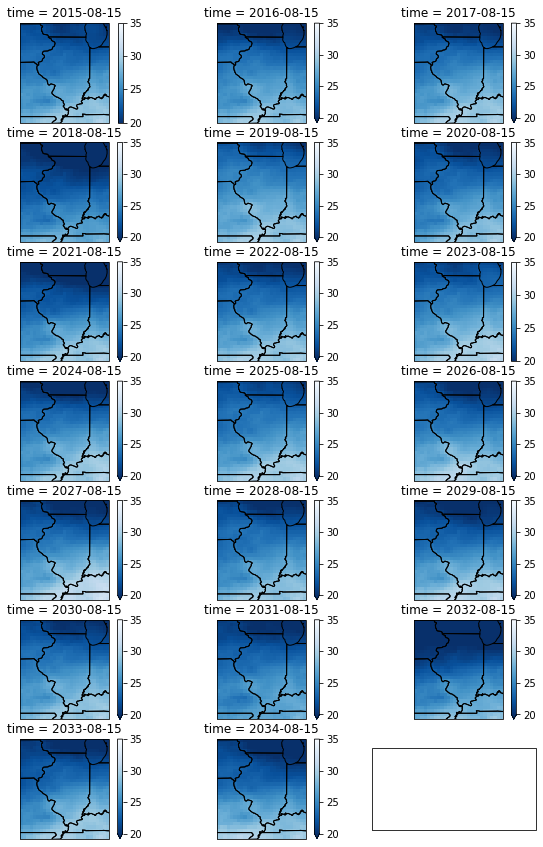

In [25]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, ax = plt.subplots(7,3, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax = ax.flatten()

i = 0
for year in range(2015,2035):
    dataset.sel(time=str(year)+'-08-15T00:00:00').mean('model').plot.pcolormesh(x='lon', y='lat', ax=ax[i],
                                                transform=ccrs.PlateCarree(), cmap='Blues_r', vmin=20, vmax=35)
    ax[i].add_feature(cfeature.STATES)
    i += 1

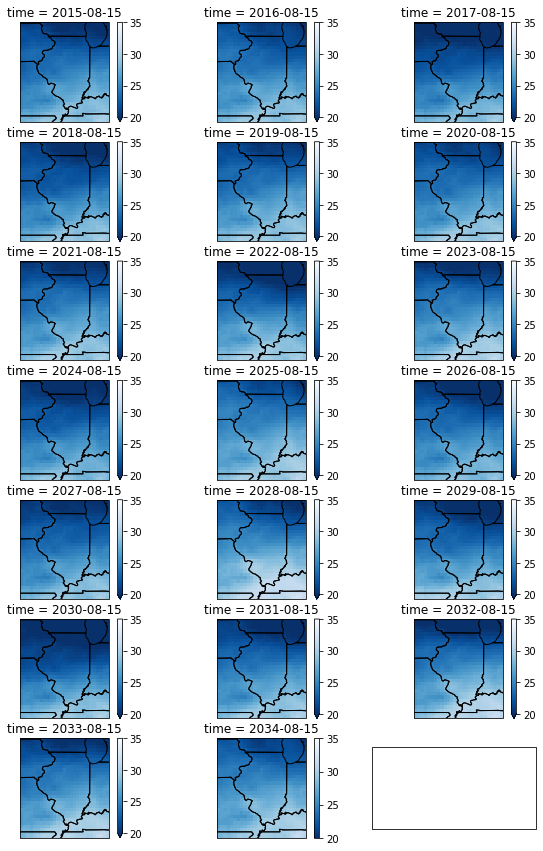

In [6]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, ax = plt.subplots(7,3, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax = ax.flatten()

i = 0
for year in range(2015,2035):
    dataset.sel(time=str(year)+'-08-15T00:00:00').mean('model').plot.pcolormesh(x='lon', y='lat', ax=ax[i],
                                                transform=ccrs.PlateCarree(), cmap='Blues_r', vmin=20, vmax=35)
    ax[i].add_feature(cfeature.STATES)
    i += 1

# Wind Magnitude